# Morphogenesis with Attention/Transformer Cellular Automata

Let's use the code from `Render_MHA.ipynb` to train self-assembly into a particle system with dynamics defined by a multi-head attention block. 

We will compute the $\ell_2$ distance between the target image and the particle system projection (Gaussian bitmap) and optimize the weights accordingly. 

I honestly don't know if the single MHA will be able to do it -- or if we will need multiple layers. I have a hunch that we can do this with an MHA and a non-linearity given enough latent states. 

In [1]:
## Import box
import numpy as np 
import matplotlib.pyplot as plt

import torch 
from torch import nn

from tqdm import tqdm
import os
import glob 
import cv2

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cuda


/home/aman/Transformer_Phase_Space/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 0: Dynamical MHA Functions

In [2]:
def RGB_render_particles_to_bitmap(X, x_res, y_res, sigma=1.0, scale_sigma=False):
    """
    Renders colored particles as Gaussian distributions on an RGB bitmap.

    Args:
        X (torch.Tensor): A tensor of shape [N, d] where d >= 5, with the first two dimensions
                          representing particle positions and the next three dimensions
                          representing RGB colors of each particle.
        x_res (int): The resolution of the bitmap along the x-axis.
        y_res (int): The resolution of the bitmap along the y-axis.
        sigma (float): The standard deviation of the Gaussians in pixels.
        scale_sigma (bool): If True, scales sigma by the same factor as positions.

    Returns:
        torch.Tensor: An RGB bitmap of shape [x_res, y_res, 3] with rendered Gaussian
                      distributions of particles, each colored according to its RGB value.
    """
    # Initialize an empty RGB bitmap of shape [y_res, x_res, 3]
    rgb_bitmap = torch.zeros((y_res, x_res, 3)).to(X.device)

    # Scale particle positions to fit within [-1, 1]
    min_pos = torch.min(X[:, 0:2], dim=0)[0]
    max_pos = torch.max(X[:, 0:2], dim=0)[0]
    scale_factor = torch.max(max_pos - min_pos) / 2
    scaled_X = (X[:, 0:2] - (min_pos + scale_factor)) / scale_factor

    # Optionally scale sigma
    if scale_sigma:
        sigma *= scale_factor

    # Generate a meshgrid for the bitmap coordinates
    x = torch.linspace(-1, 1, steps=x_res).to(X.device)
    y = torch.linspace(-1, 1, steps=y_res).to(X.device)
    xx, yy = torch.meshgrid(x, y, indexing="ij")
    # print("xx device: ", xx.device)

    # For each particle, add its colored Gaussian distribution to the RGB bitmap
    for i in range(X.shape[0]):
        # Calculate Gaussian distribution
        gx = torch.exp(-((xx - scaled_X[i, 0]) ** 2) / (2 * sigma ** 2))
        gy = torch.exp(-((yy - scaled_X[i, 1]) ** 2) / (2 * sigma ** 2))
        gaussian = gx * gy

        # Apply color to Gaussian
        for channel in range(3):
            rgb_bitmap[:, :, channel] += gaussian * X[i, channel + 2]

    # Normalize the RGB bitmap so the maximum Gaussian value is 1 for each channel
    max_val = torch.max(rgb_bitmap.view(-1, 3), dim=0)[0]
    rgb_bitmap /= max_val.clamp(min=1)  # Avoid division by zero

    return rgb_bitmap

In [3]:
def visualize_state_matrix(X_, 
                           title='State Visualization: XY-RGB State Interpretation', 
                           savename='../figs/test.png', 
                           scale_sigma=False,
                           show=False):
    # make the directories leading to savename if they don't exist 
    os.makedirs(os.path.dirname(savename), exist_ok=True)
    
    X = X_.detach().cpu()
    bitmap = RGB_render_particles_to_bitmap(X, x_res, y_res, sigma=0.03, scale_sigma=scale_sigma)
    plt.imshow(bitmap.numpy())
    plt.title(title)
    plt.savefig(savename)
    if show:
        plt.show()
    plt.close()

    

In [4]:
def run_sim(state_matrix, 
            dynamics_model,
            num_iters = 50, 
            dt = 0.02 / 100, 
            noise_factor = 0.005,
            fig_folder=None,
            frame_period = 2000):
    state_tensor_list = []
    # for i in tqdm(range(num_iters)): 
    for i in range(num_iters): 
        if i > 0: 
            state_matrix = state_tensor_list[-1]
        
        if type(dynamics_model) == nn.MultiheadAttention:
            dx, _ = dynamics_model(state_matrix, state_matrix, state_matrix)
        elif type(dynamics_model) == torch.nn.modules.transformer.TransformerEncoderLayer:
            dx = dynamics_model(state_matrix)
        elif type(dynamics_model) == torch.nn.modules.transformer.TransformerEncoder:
            dx = dynamics_model(state_matrix)
        else: 
            print("Type of dynamics model: ", type(dynamics_model))
            raise ValueError("dynamics_model must be a nn.MultiheadAttention or nn.Transformer")
        # dxy = dx[:,:,0:2]
        dxy = dx
        # print("dxy shape: ", dxy.shape)

        # noise up the dxy 
        noise = torch.randn_like(dxy).to(DEVICE)*noise_factor  # 0 mean, variance 1
        dxy += noise

        # let's try normalizing dxy -- right now the variance is super tight.
        dxy_std, dxy_mean = torch.std_mean(dxy)
        dxy = dxy - dxy_mean
        dxy = dxy/dxy_std

        # dxyrgb = torch.zeros(dx.shape).to(DEVICE) 
        dxyrgb = dxy

        state_tensor_list.append(state_matrix + dxyrgb*dt)
        
        # savename = f'../figs/{fig_folder}/frame_{str(i).zfill(3)}.png'
        if fig_folder is not None and i % frame_period == 0: 
            with torch.no_grad():
                visualize_state_matrix(state_tensor_list[-1][:,0,:], 
                                    scale_sigma=True,
                                    savename=f'../figs/{fig_folder}/frame_{str(i//frame_period).zfill(3)}.png')
    return state_matrix, state_tensor_list


## 1: Hyperparameters

In [5]:
## Setting up the MHA 
embed_dim = 40      # Key and query dimension expected in the input.
key_dim = embed_dim # Expected dimension of the keys + queries
val_dim = embed_dim # Expected dimension of the 
num_heads = 4       # Number of heads in the MHA.
# multihead_attn = nn.MultiheadAttention(embed_dim, num_heads, kdim=key_dim, vdim=val_dim, bias=True).to(DEVICE) # value/outpu

## Setting up the state matrix 
N = 61             # Number of particles/sequence length
num_batch = 1
state_matrix = torch.rand(N, num_batch, val_dim).to(DEVICE) # uniform [0, 1]
print("State matrix shape (N, batch, particle_state_dim): ", state_matrix.shape)

# Simulation time, dt, noise
num_iters = 20
dt = 0.02
noise_factor = 0.0
dropout = 0.005

# Render/projection settings
target_image_path = '../figs/target_image.png'
x_res = 300
y_res = 300
frame_period = 1
fig_folder = 'anim10'
# frame_period = 2000

n_train_steps = 200

State matrix shape (N, batch, particle_state_dim):  torch.Size([61, 1, 40])


In [6]:
# make a transformer block with sequential multihead attention and feedforward layers
transformer_block = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout = dropout).to(DEVICE)
transformer = nn.TransformerEncoder(transformer_block, num_layers=2).to(DEVICE)

transformer_block(state_matrix).shape
transformer(state_matrix).shape 

transformer_block = transformer

In [7]:
transformer_block
print(type(transformer_block))
# print(transformer_block)

<class 'torch.nn.modules.transformer.TransformerEncoder'>


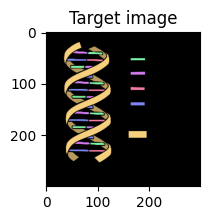

Target image shape:  (300, 300, 3)
Target image dtype:  float32
Target image min/max:  0.0 0.9647059


In [8]:
# Grabbing the target image 

target_image = cv2.imread(target_image_path)
target_image = cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB)
target_image = cv2.resize(target_image, (x_res, y_res))

# convert to float, normalize to [0, 1]
target_image = target_image.astype(np.float32) / 255.0

# make matplotlib plot small
plt.figure(figsize=(2, 2))

plt.imshow(target_image)
plt.title("Target image")

plt.show()
print("Target image shape: ", target_image.shape)
print("Target image dtype: ", target_image.dtype)
print("Target image min/max: ", target_image.min(), target_image.max())

# move to torch and to DEVICE
target_image = torch.tensor(target_image).to(DEVICE)

## 2: Training Loop

In [9]:
losses = []

state_matrix_0 = torch.rand(N, num_batch, val_dim).to(DEVICE)
state_matrix_0 = state_matrix_0.detach().requires_grad_()

torch.autograd.set_detect_anomaly(True)

In [10]:
loss_period = 100
learning_rate = 0.001
n_train_steps = 2500

# (100, 0.01, 200) -> 0.051ish loss
# (100, 0.005, 200) -> 0.049ish

In [24]:
num_iters = 40

In [25]:
# set up optimizer for transformer_block params
optimizer = torch.optim.Adam(transformer_block.parameters(), lr=learning_rate)

# loop thru iterations with tqdm 
pbar = tqdm(range(n_train_steps))

for iter in pbar: 
    # make a random starting state matrix
    # state_matrix = torch.rand(N, num_batch, val_dim).to(DEVICE) # uniform [0, 1]
    # copy over state_matrix_0 to state_matrix 
    state_matrix = state_matrix_0.clone()
    # set requires grad true
    # state_matrix = state_matrix.detach()

    # Run the dynamics
    end_matrix, state_tensor_list = run_sim(state_matrix, 
                            transformer_block,
                           num_iters = num_iters, 
                           dt = dt, 
                           noise_factor = noise_factor,
                           fig_folder=None,
                           frame_period = -1)
    
    # Render the end matrix
    end_bitmap = RGB_render_particles_to_bitmap(end_matrix[:,0,:], 
                                                x_res, 
                                                y_res, 
                                                sigma=0.03, 
                                                scale_sigma=True)

    # print shape and datatype 
    # print("End bitmap shape: ", end_bitmap.shape)
    # print("End bitmap dtype: ", end_bitmap.dtype)

    # Plot the end bitmap
    # plt.imshow(end_bitmap.detach().cpu().numpy())

    # Compute loss with target image
    loss = torch.mean((end_bitmap - target_image) ** 2)
    # cnt = 0
    # for state_tensor in state_tensor_list: 
    #     cnt += 1
    #     if cnt % 100 == 0:
    #         projection = RGB_render_particles_to_bitmap(end_matrix[:,0,:], x_res, y_res, sigma=0.03, scale_sigma=True)
    #         loss += torch.mean((projection - target_image) ** 2)
    #     # print("Loss: ", loss.item())
    # loss /= (cnt//100+1)
    
    # print("Loss: ", loss.item())
    losses.append(loss.item())
    pbar.set_description(f"Loss: {loss.item():.4f}")

    # Backpropagate
    loss.backward()

    # Update the mha parameters
    optimizer.step()
    optimizer.zero_grad()
    

    # # Update the mha parameters
    # with torch.no_grad():
    #     for param in transformer_block.parameters():
    #         param -= learning_rate * param.grad
    #     transformer_block.zero_grad()

        # optimize state_matrix 
        # state_matrix_0 -= learning_rate*.01 * state_matrix_0.grad

Loss: 0.0246:  19%|█▉        | 470/2500 [10:05<43:34,  1.29s/it]


KeyboardInterrupt: 

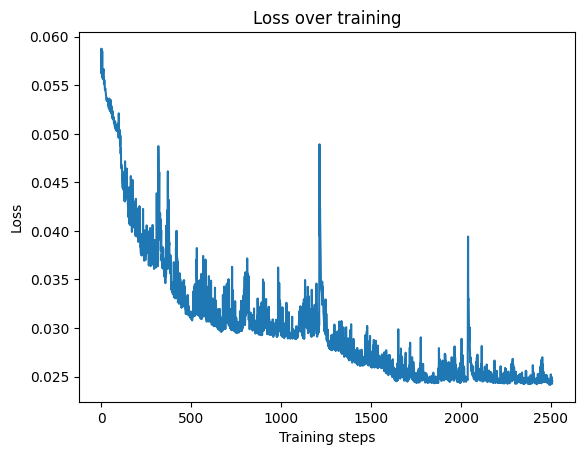

In [26]:
# loss plot 
plt.plot(losses)
plt.title("Loss over training")
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.show()

In [27]:
state_matrix.grad

## 3: Running the Simulation/Training, Render a Video

In [35]:
# reset output directory contents
png_path = f'../figs/{fig_folder}/*.png'

os.system(f'rm {png_path}')
os.makedirs(f'../figs/{fig_folder}', exist_ok=True)

In [36]:
# re-initialize state_matrix 
# state_matrix_0 = torch.rand(N+1, num_batch, val_dim).to(DEVICE)
state_matrix = state_matrix_0.clone()

In [37]:
with torch.no_grad():
    state_matrix, state_tensor_list = run_sim(state_matrix,
                            # multihead_attn,
                            transformer_block,  
                            num_iters=num_iters,
                            dt=dt,
                            noise_factor=noise_factor,
                            fig_folder=fig_folder,
                            frame_period=frame_period)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

In [38]:
# get the current time as a string 
import datetime
now = datetime.datetime.now()
now_str = now.strftime("%Y-%m-%d_%H-%M-%S")

png_path = f'../figs/{fig_folder}/*.png'
img_array = []
for filename in sorted(glob.glob(png_path)): 
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width, height)
    img_array.append(img)

mp4_name = f'../figs/{fig_folder}_{now_str}.mp4'
out = cv2.VideoWriter(mp4_name, cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [39]:
print("Written to ", mp4_name)

Written to  ../figs/anim10_2024-03-01_13-58-47.mp4


In [40]:
state_matrix

tensor([[[ 0.9626,  1.3017,  0.3354,  ..., -1.5118, -0.0146, -0.8772]],

        [[ 0.8432,  0.0892,  0.4236,  ..., -1.1995, -0.3329, -0.7056]],

        [[ 0.9488,  1.3849,  0.2126,  ..., -0.4422,  0.7956,  0.3574]],

        ...,

        [[ 0.0780,  0.6647,  1.1861,  ..., -0.6441,  0.3004, -0.8644]],

        [[ 0.4278,  1.3094, -0.2695,  ..., -0.4679,  0.1782,  0.4808]],

        [[ 0.0386,  1.3517,  0.4476,  ..., -0.6688,  0.0624, -0.6691]]],
       device='cuda:0')

In [41]:
# compute loss
end_bitmap = RGB_render_particles_to_bitmap(state_matrix[:,0,:], x_res, y_res, sigma=0.03, scale_sigma=True)
loss = torch.mean((end_bitmap - target_image) ** 2)
print("Loss: ", loss.item())

Loss:  0.024207565933465958
